In [1]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics import accuracy_score,classification_report,pairwise_distances_argmin_min,silhouette_score, hamming_loss, f1_score, precision_score, recall_score, jaccard_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from preprocess_data import preprocess_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_distances,pairwise_distances
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.linear_model import SGDClassifier
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
2024-09-21 12:34:15.036010: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-21 12:34:15.036194: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-21 12:34:16.257454: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-

In [2]:
dataset_name = 'academic_papers' # choose from 'imdb', 'academic_papers', 'legal', 'reviews', 'ecommerce'
data = preprocess_data(dataset_name)
#data['genre'].value_counts().plot(kind='bar')

In [3]:
if dataset_name == 'imdb' or dataset_name == 'academic_papers':
    data['num_genres'] = data['genre'].apply(len)
    data = data[data['num_genres'] == 1]
    
descriptions = data['description_processed'].tolist()
genres = data['genre'].apply(lambda x: x[0]).to_list() if dataset_name == 'academic_papers' else data['genre'].tolist() 
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(genres)
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
X = model.encode(descriptions, show_progress_bar=True)

/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Batches: 100%|██████████| 684/684 [07:29<00:00,  1.52it/s]


In [4]:
initial_train_size = 250
iterations = 20
uncertainty_threshold = 0.2
budget_per_iteration = 500
methods = ['random', 'entropy', 'margin', 'cluster']    

In [5]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_full_normalized = normalize(X_train_full, axis=1, norm='l2')
X_test_normalized = normalize(X_test, axis=1, norm='l2')
np.random.seed(42)
initial_indices = np.random.choice(len(X_train_full_normalized), initial_train_size, replace=False)

### Code for Non-random Centroid Initialization

In [6]:
# centroid_sentences = genre_descriptions = [
#     "intense physical confrontations fast paced sequences featuring combat explosions high stakes conflict",
#     "epic journeys heroic quests dangerous adventures often in fantastical settings exploration unknown",
#     "animated storytelling visual artistry non-human characters imaginative worlds surreal narratives",
#     "detailed accounts real-life individuals focusing on personal achievements significant historical moments",
#     "comedic scenarios witty dialogues humor-based interactions aimed at evoking laughter entertainment",
#     "depictions organized crime criminal behavior investigations heists underworld activities law enforcement",
#     "deep emotional narratives character evolution often dealing with life-altering events personal challenges",
#     "family-friendly themes focusing on relationships nurturing positive lessons designed for younger audiences",
#     "magical realms supernatural beings mystical adventures crossing boundaries between reality imagination",
#     "historical recreations focusing on pivotal events important eras real historical figures shaping world events",
#     "crafted to evoke fear suspense often involving supernatural forces psychological terror or extreme violence",
#     "stories centered around music performers musicians using songs as narrative devices to advance plot",
#     "musical storytelling with elaborate performances dance sequences centered around theatrical music numbers",
#     "intricate narratives involving crime detective work solving mysteries uncovering secrets unexpected twists",
#     "narratives centered on romantic relationships emotional intimacy personal growth often amidst challenges",
#     "explorations advanced technology futuristic societies space travel speculative science uncharted concepts",
#     "competitive sports athletic achievement depicting struggles victories focus on physical and mental endurance",
#     "psychological tension high stakes thrillers featuring danger suspense shocking revelations complex plots",
#     "military combat war strategies depictions battles focusing on heroism sacrifice wartime experiences",
#     "western frontier themes cowboys outlaws gunfights rugged landscapes lawlessness moral dilemmas"
# ]

# centroid_vecs = model.encode(centroid_sentences, show_progress_bar=True)
# centroid_vecs = normalize(centroid_vecs, axis=1, norm='l2')
# centroid_vecs = np.array(centroid_vecs)

In [7]:
# def sample_non_random_init(method, X_train, X_pool, remaining_indices, budget):
#     if method == 'random':
#         return np.random.choice(remaining_indices, budget, replace=False)
    
#     elif method == 'cluster':
#         num_clusters = 20
#         #clustering = faiss.Clustering(X_train.shape[1], num_clusters)
#         #clustering.verbose = False
#         #clustering.niter = 50
#         remaining_data = np.array([X_pool[i] for i in remaining_indices]).astype('float32')
#         #index_flat = faiss.IndexFlatIP(X_train.shape[1])
#         #index_flat.add(centroid_vecs.astype('float32'))
#         #clustering.train(remaining_data, index_flat)
#         #D, cluster_assignments = index_flat.search(remaining_data, 1)
#         #cluster_assignments = cluster_assignments.flatten()
#         #centroids = faiss.vector_to_array(clustering.centroids).reshape(num_clusters, X_train.shape[1])
#         kmeans = KMeans(n_clusters=num_clusters, init=centroid_vecs, n_init=1, max_iter=100)
#         kmeans.fit(remaining_data)
#         cluster_assignments = kmeans.labels_
#         final_centroids = kmeans.cluster_centers_

#         selected_indices = []
#         for cluster in range(num_clusters):
#             cluster_indices = [i for i, label in zip(remaining_indices, cluster_assignments) if label == cluster]
#             if cluster_indices:
#                 num_to_select_from_cluster = min((int((500/num_clusters)/2)), int(len(cluster_indices)/2))
#                 cluster_data = X_pool[np.array(cluster_indices)]
#                 cluster_center = final_centroids[cluster].reshape(1, -1)
#                 distances = np.linalg.norm(cluster_data - cluster_center, axis=1)
#                 #distances, _ = index_flat.search(cluster_center, len(cluster_indices))
#                 closest_samples = set([cluster_indices[i] for i in distances[0].argsort()[:num_to_select_from_cluster]])

#                 pairwise_distances_matrix = pairwise_distances(cluster_data)
#                 diversity_scores = pairwise_distances_matrix.mean(axis=1)
#                 most_diverse_indices = set([cluster_indices[i] for i in np.argsort(-diversity_scores)[:num_to_select_from_cluster]])
#                 selected_indices.extend(list(closest_samples.union(most_diverse_indices)))

#         return selected_indices

### Continue Here

In [8]:
def sample(method, X_train, X_pool, remaining_indices, budget, clf):
    if method == 'random':
        return np.random.choice(remaining_indices, budget, replace=False)
    
    elif method == 'margin':
        probs = clf.predict_proba(X_pool)
        sorted_probs = np.sort(probs, axis=1) 
        margins = sorted_probs[:, -1] - sorted_probs[:, -2]
        return np.argsort(margins)[:budget]  
    
    elif method == 'entropy':
        probs = clf.predict_proba(X_pool)
        entropies = -np.sum(probs * np.log(probs), axis=1)
        return np.argsort(entropies)[:budget]
    
    elif method == 'cluster':
        num_clusters = 20
        clustering = faiss.Clustering(X_train.shape[1], num_clusters)
        clustering.verbose = False
        clustering.niter = 50
        remaining_data = np.array([X_pool[i] for i in remaining_indices]).astype('float32')
        index_flat = faiss.IndexFlatIP(X_train.shape[1])
        clustering.train(remaining_data, index_flat)
        D, cluster_assignments = index_flat.search(remaining_data, 1)
        cluster_assignments = cluster_assignments.flatten()
        centroids = faiss.vector_to_array(clustering.centroids).reshape(num_clusters, X_train.shape[1])

        selected_indices = []
        for cluster in range(num_clusters):
            cluster_indices = [i for i, label in zip(remaining_indices, cluster_assignments) if label == cluster]
            if cluster_indices:
                num_to_select_from_cluster = min((int((500/num_clusters)/2)), int(len(cluster_indices)/3))
                cluster_data = X_pool[np.array(cluster_indices)]
                cluster_center = centroids[cluster].reshape(1, -1)
                distances, _ = index_flat.search(cluster_center, len(cluster_indices))
                closest_samples = [cluster_indices[i] for i in distances[0].argsort()[:num_to_select_from_cluster]]
                selected_indices.extend(closest_samples)

                pairwise_distances_matrix = pairwise_distances(cluster_data)
                diversity_scores = pairwise_distances_matrix.mean(axis=1)
                most_diverse_indices = set([cluster_indices[i] for i in np.argsort(-diversity_scores)[:num_to_select_from_cluster]])
                selected_indices.extend(most_diverse_indices)

                probs = clf.predict_proba(cluster_data)
                uncertainty = 1 - np.max(probs, axis=1)
                sorted_indices = np.argsort(-uncertainty)
                selected_cluster_indices = [cluster_indices[i] for i in sorted_indices[:num_to_select_from_cluster]]
                selected_indices.extend(selected_cluster_indices)

        return list(set(selected_indices))

In [9]:
acc_dict, f1_dict, prec_dict, rec_dict = {}, {}, {}, {}
for method in methods:
    print(f'Running active learning with {method} sampling')
    clf = SGDClassifier(loss='log_loss', random_state=42)
    accuracies, f1_scores, precs, recalls = [], [], [], []
    X_train = X_train_full_normalized[initial_indices]
    y_train = np.array(y_train_full)[initial_indices]
    remaining_indices = list(set(range(len(X_train_full_normalized))) - set(initial_indices))
    for iteration in range(iterations):
        clf.partial_fit(X_train, y_train, classes=np.unique(y_train_full))
        y_pred = clf.predict(X_test_normalized)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        prec = precision_score(y_test, y_pred, average='macro')
        rec = recall_score(y_test, y_pred, average='macro')
        accuracies.append(acc)   
        f1_scores.append(f1)
        precs.append(prec)
        recalls.append(rec)
        print(f'Iteration {iteration + 1}/{iterations} - Accuracy: {acc}, F1: {f1}, Precision: {prec}, Recall: {rec}')
        selected_indices = sample(method, X_train, X_train_full_normalized, remaining_indices, budget_per_iteration, clf)
        X_train = np.vstack((X_train, X_train_full_normalized[selected_indices]))
        y_train = np.concatenate((y_train, np.array(y_train_full)[selected_indices]))
        remaining_indices = list(set(remaining_indices) - set(selected_indices))
        
    print(classification_report(y_test, y_pred))
    acc_dict[method] = accuracies
    f1_dict[method] = f1_scores
    prec_dict[method] = precs
    rec_dict[method] = recalls
        

Running active learning with random sampling
Iteration 1/20 - Accuracy: 0.8943517036359478, F1: 0.6594393785883147, Precision: 0.6563256353828612, Recall: 0.7038401512834621
Iteration 2/20 - Accuracy: 0.9423736565286989, F1: 0.7289922532164219, Precision: 0.8428283441105667, Recall: 0.6648641962718264
Iteration 3/20 - Accuracy: 0.9439743882917905, F1: 0.7027584913515671, Precision: 0.80148915640123, Recall: 0.6921232019224354
Iteration 4/20 - Accuracy: 0.9549508346672765, F1: 0.6869542027335731, Precision: 0.8549513895013208, Recall: 0.6538487627150578
Iteration 5/20 - Accuracy: 0.9570089183626801, F1: 0.716522018473265, Precision: 0.849990501951782, Recall: 0.6756504760524572
Iteration 6/20 - Accuracy: 0.9560942144980562, F1: 0.6943046119401091, Precision: 0.8891037000288261, Recall: 0.6843541896721593
Iteration 7/20 - Accuracy: 0.9602103818888634, F1: 0.7216985686539784, Precision: 0.8508760914929921, Recall: 0.6849120839621872
Iteration 8/20 - Accuracy: 0.9597530299565515, F1: 0.709

/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 6/20 - Accuracy: 0.9437457123256345, F1: 0.587028692381485, Precision: 0.598569905643259, Recall: 0.5775625416754249
Iteration 7/20 - Accuracy: 0.9405442487994512, F1: 0.5797559911554189, Precision: 0.5994420462092349, Recall: 0.5647938606539116
Iteration 8/20 - Accuracy: 0.941458952664075, F1: 0.5923591769213888, Precision: 0.9331188633631808, Recall: 0.5730302739217342
Iteration 9/20 - Accuracy: 0.9325405899839927, F1: 0.5718680030035822, Precision: 0.9389709177457494, Recall: 0.5395002050288619
Iteration 10/20 - Accuracy: 0.9380288131717357, F1: 0.574378877578821, Precision: 0.6020856064817698, Recall: 0.5547971120259039


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 11/20 - Accuracy: 0.9419163045963869, F1: 0.582521074611613, Precision: 0.600167420723579, Recall: 0.5688346941073016
Iteration 12/20 - Accuracy: 0.9339126457809285, F1: 0.5647828275579186, Precision: 0.6021647969459446, Recall: 0.5406705698875718


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 13/20 - Accuracy: 0.9320832380516808, F1: 0.5605586218494382, Precision: 0.6029112655315193, Recall: 0.534447774542151
Iteration 14/20 - Accuracy: 0.9311685341870569, F1: 0.5575899265821747, Precision: 0.6050285367814728, Recall: 0.5295828403135489


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 15/20 - Accuracy: 0.930711182254745, F1: 0.5572072091706323, Precision: 0.6029069089301133, Recall: 0.5299059306442203
Iteration 16/20 - Accuracy: 0.9233935513377544, F1: 0.5399541840722275, Precision: 0.6027378225054627, Recall: 0.5080208119297799


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 17/20 - Accuracy: 0.9227075234392865, F1: 0.5385401916219797, Precision: 0.602957660630928, Recall: 0.506250900425355
Iteration 18/20 - Accuracy: 0.9179053281500115, F1: 0.5268538637984473, Precision: 0.6003422054039361, Recall: 0.49336050944984106


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 19/20 - Accuracy: 0.9137891607592042, F1: 0.516845567930893, Precision: 0.5983837678644656, Recall: 0.4827410404232924
Iteration 20/20 - Accuracy: 0.9142465126915161, F1: 0.5178293639980706, Precision: 0.5978814844154725, Recall: 0.48392098142624224


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined an

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      3747
           1       0.88      0.45      0.60       565
           2       0.00      0.00      0.00        61

    accuracy                           0.91      4373
   macro avg       0.60      0.48      0.52      4373
weighted avg       0.90      0.91      0.90      4373

Running active learning with margin sampling
Iteration 1/20 - Accuracy: 0.8943517036359478, F1: 0.6594393785883147, Precision: 0.6563256353828612, Recall: 0.7038401512834621
Iteration 2/20 - Accuracy: 0.9446604161902584, F1: 0.748169413359579, Precision: 0.7442375490342122, Recall: 0.8338979735136499
Iteration 3/20 - Accuracy: 0.9368854333409559, F1: 0.7397344225230228, Precision: 0.8777969008034203, Recall: 0.6641908203933103
Iteration 4/20 - Accuracy: 0.9108163731991767, F1: 0.6916369622852523, Precision: 0.8244495125579715, Recall: 0.7095144426387864
Iteration 5/20 - Accuracy: 0.9592956780242397, F1: 0.820486

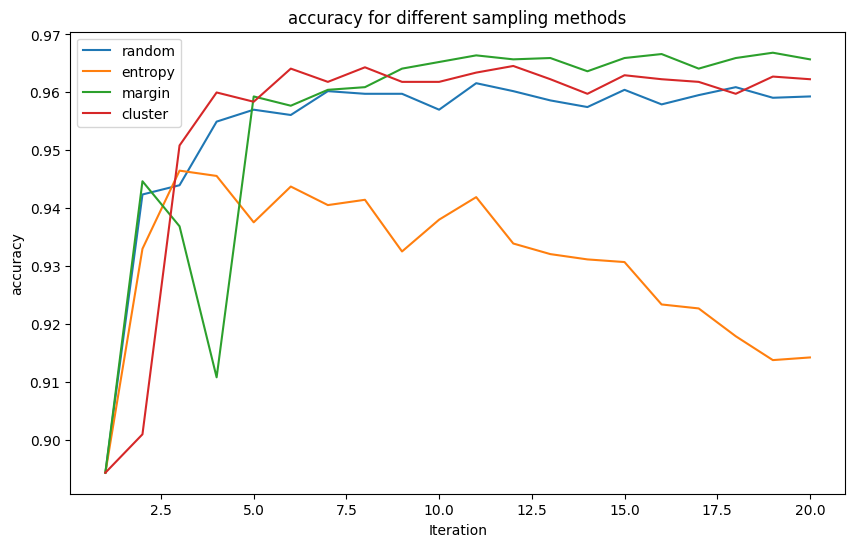

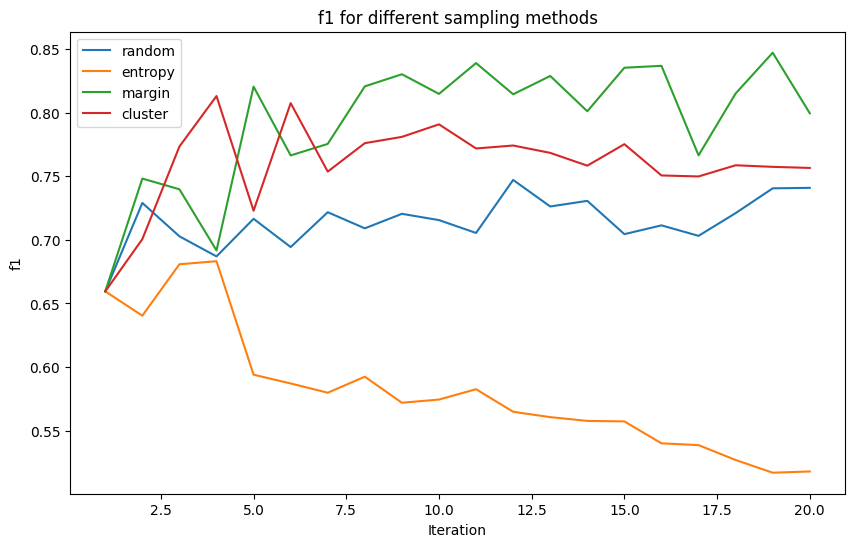

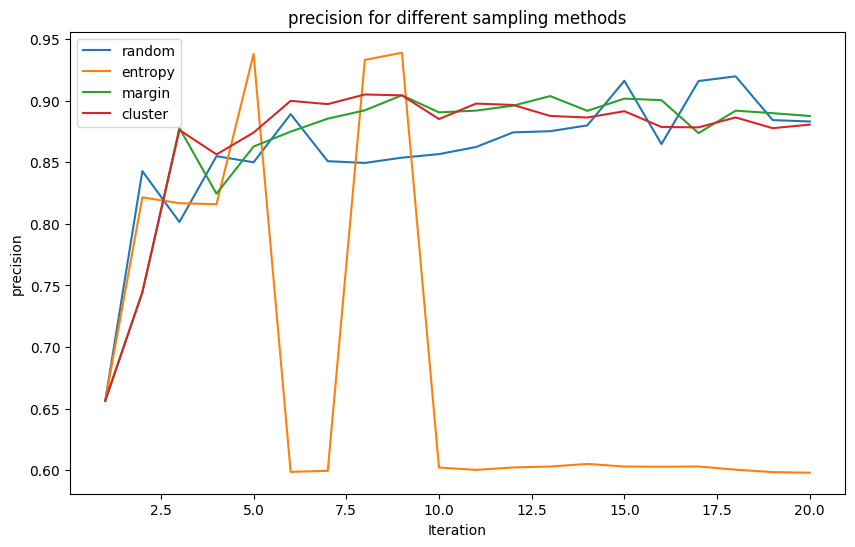

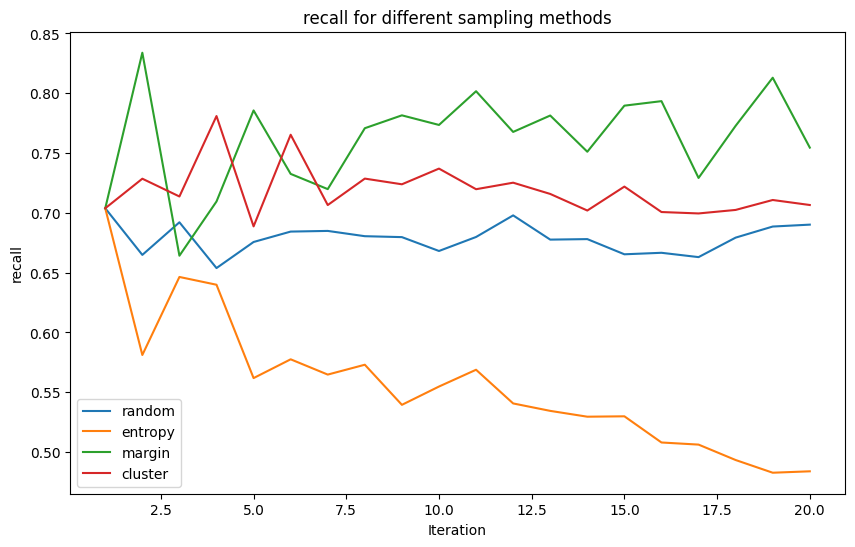

In [11]:

dics = {'accuracy': acc_dict, 'f1': f1_dict, 'precision': prec_dict, 'recall': rec_dict}
its = np.arange(1, iterations + 1)
for metric, dic in dics.items():
    plt.figure(figsize=(10, 6))
    for name, values in dic.items():
        sns.lineplot(x=its, y=values, label=name)
    plt.xlabel('Iteration')
    plt.ylabel(metric)
    plt.title(f'{metric} for different sampling methods')
    plt.legend()
    # plt.savefig(f'images/{dataset_name}_{metric}_active_learning.png')
    plt.savefig(f'../data/images/{dataset_name}_{metric}_active_learning.png')
    plt.show()
 
